Import necessary libraries.

In [1]:
import numpy as np
import pandas as pd
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
import pickle
from numpy import log 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  
import matplotlib.pyplot as plt 
import statsmodels.api as sm 
from statsmodels.graphics.tsaplots import plot_predict   
import itertools

Load the dataset

In [2]:
df = pd.read_csv('colombo_rh_2012-2018.csv')
df

,station_id,station_name,element_name,year,month,day,obs_val
0,43466,COLOMBO,RHMAX,2012,1,1,91.0
1,43466,COLOMBO,RHMAX,2012,1,2,90.0
2,43466,COLOMBO,RHMAX,2012,1,3,89.0
3,43466,COLOMBO,RHMAX,2012,1,4,89.0
4,43466,COLOMBO,RHMAX,2012,1,5,95.0
...,...,...,...,...,...,...,...
4398,43466,COLOMBO,RHMAX,2018,12,27,90.0
4399,43466,COLOMBO,RHMAX,2018,12,28,88.0
4400,43466,COLOMBO,RHMAX,2018,12,29,76.0
4401,43466,COLOMBO,RHMAX,2018,12,30,81.0


Drop the RHMIN value
Some date has both RHMAX and RHMIN observation values.

In [3]:
df = df.drop(df[df['element_name'] == 'RHMIN'].index)
df

,station_id,station_name,element_name,year,month,day,obs_val
0,43466,COLOMBO,RHMAX,2012,1,1,91.0
1,43466,COLOMBO,RHMAX,2012,1,2,90.0
2,43466,COLOMBO,RHMAX,2012,1,3,89.0
3,43466,COLOMBO,RHMAX,2012,1,4,89.0
4,43466,COLOMBO,RHMAX,2012,1,5,95.0
...,...,...,...,...,...,...,...
4398,43466,COLOMBO,RHMAX,2018,12,27,90.0
4399,43466,COLOMBO,RHMAX,2018,12,28,88.0
4400,43466,COLOMBO,RHMAX,2018,12,29,76.0
4401,43466,COLOMBO,RHMAX,2018,12,30,81.0


create new dataframe with new columns

In [4]:
df = df[['year','month','day','obs_val']]
df

,year,month,day,obs_val
0,2012,1,1,91.0
1,2012,1,2,90.0
2,2012,1,3,89.0
3,2012,1,4,89.0
4,2012,1,5,95.0
...,...,...,...,...
4398,2018,12,27,90.0
4399,2018,12,28,88.0
4400,2018,12,29,76.0
4401,2018,12,30,81.0


Drop the null values

In [5]:
df = df.dropna()

count the null values

In [6]:
df.isna().sum()

year       0
month      0
day        0
obs_val    0
dtype: int64

Count the duplicate values.

In [7]:
df.duplicated().sum()

365

Drop the duplicated value.

In [8]:
df = df.drop_duplicates()
df.shape

(2557, 4)

In [9]:
df.head(65)

,year,month,day,obs_val
0,2012,1,1,91.0
1,2012,1,2,90.0
2,2012,1,3,89.0
3,2012,1,4,89.0
4,2012,1,5,95.0
...,...,...,...,...
62,2012,3,1,90.0
63,2012,3,2,84.0
64,2012,3,3,84.0
65,2012,3,4,88.0


Combine the Year,month,day columns

In [10]:
cols=["year","month","day"]
df['date'] = df[cols].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")

convert the date into date format

In [11]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df

,year,month,day,obs_val,date
0,2012,1,1,91.0,2012-01-01
1,2012,1,2,90.0,2012-01-02
2,2012,1,3,89.0,2012-01-03
3,2012,1,4,89.0,2012-01-04
4,2012,1,5,95.0,2012-01-05
...,...,...,...,...,...
2937,2018,12,27,90.0,2018-12-27
2938,2018,12,28,88.0,2018-12-28
2939,2018,12,29,76.0,2018-12-29
2940,2018,12,30,81.0,2018-12-30


In [12]:
df['date'] =  pd.to_datetime(df['date'], format='%Y-%m-%d')
df.drop(['year', 'month', 'day'], axis=1,inplace=True)
df

,obs_val,date
0,91.0,2012-01-01
1,90.0,2012-01-02
2,89.0,2012-01-03
3,89.0,2012-01-04
4,95.0,2012-01-05
...,...,...
2937,90.0,2018-12-27
2938,88.0,2018-12-28
2939,76.0,2018-12-29
2940,81.0,2018-12-30


Set date column as index

In [13]:
df = df.set_index('date')

In [14]:
df

,obs_val
date,
2012-01-01,91.0
2012-01-02,90.0
2012-01-03,89.0
2012-01-04,89.0
2012-01-05,95.0
...,...
2018-12-27,90.0
2018-12-28,88.0
2018-12-29,76.0


check the dataset whether it is stationary or not by using plot
1.Constant mean
2.Constant varience
3.No seasonilty

<Axes: xlabel='date'>

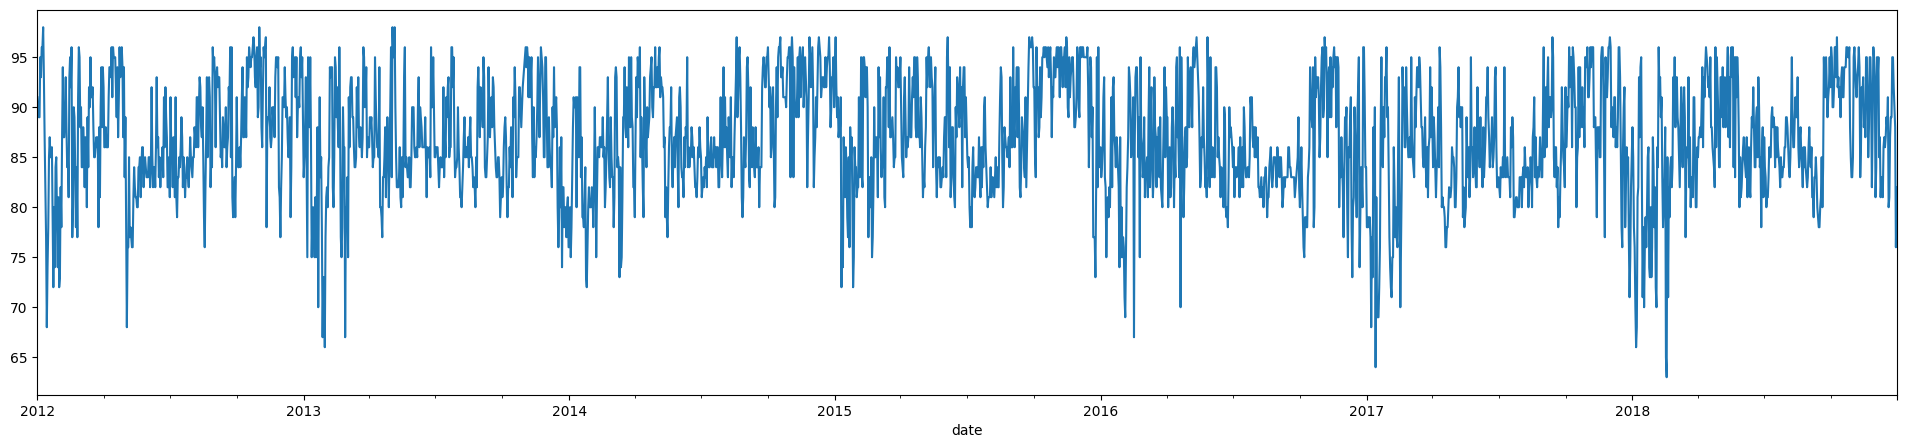

In [15]:
df['obs_val'].plot(figsize=(24,5))

Next we have to find the p, d, & q values. (order of AR, I, & MA terms). We can do that using the Partial Autocorrelation (PACF) plot & ACF plot as follows. But we can easily take them using 'autoarmia'.

In [16]:
def adf_test(dataset):
     dftest = adfuller(dataset, autolag = 'AIC')
     print("1. ADF : ",dftest[0])
     print("2. P-Value : ", dftest[1])
     print("3. Num Of Lags : ", dftest[2])
     print("4. Num Of Observations Used For ADF Regression:",dftest[3])
     print("5. Critical Values :")
     for key, val in dftest[4].items():
         print("\t",key, ": ", val)

adf_test(df['obs_val'])

1. ADF :  -7.951975596559519
2. P-Value :  3.1084526115129724e-12
3. Num Of Lags :  16
4. Num Of Observations Used For ADF Regression: 2540
5. Critical Values :
	 1% :  -3.4329271342415577
	 5% :  -2.8626785721005303
	 10% :  -2.5673761046872094


Apply the auto arima model to find what are the best P,D,Q values.

In [17]:
stepwise_fit = auto_arima(df['obs_val'], trace=True,
suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=14873.008, Time=0.74 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=16163.865, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=14928.154, Time=0.13 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=15376.137, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=30098.217, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=14865.033, Time=1.43 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=15094.561, Time=0.38 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=14870.516, Time=1.06 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=14853.846, Time=1.79 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=15002.144, Time=0.46 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=14858.688, Time=1.26 sec
 ARIMA(1,0,4)(0,0,0)[0] intercept   : AIC=14847.455, Time=2.32 sec
 ARIMA(0,0,4)(0,0,0)[0] intercept   : AIC=14948.370, Time=0.64 sec
 ARIMA(2,0,4)(0,0,0)[0] intercept   : AIC=14851.380, Time=2.54 sec
 ARIMA(1,0,5)(0,0,0

# The auto_arima function is part of the pmdarima package, which provides an implementation of the ARIMA algorithm.
# This function automatically selects the optimal parameters for the ARIMA model using a stepwise approach. 
# It fits multiple ARIMA models with different parameters and selects the best one based on the AIC value.

Split the data set into train test data

In [18]:
train=df.iloc[:-100]
test=df.iloc[-100:]
print(train.shape,test.shape)

(2457, 1) (100, 1)


Check the mean squared error (MSE)

 Assess how well an ARIMA model fits the time series data. The MSE is a measure of the average squared difference between the predicted values and the actual values of the time series data.

C:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


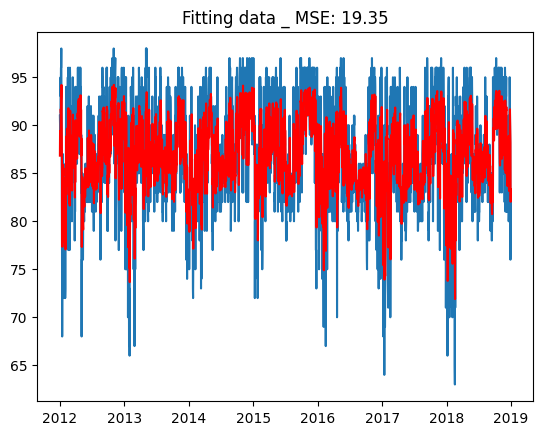

In [19]:
model = ARIMA(df.obs_val, order=(1,0,4))  
results_MA = model.fit()  
plt.plot(df.obs_val)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('Fitting data _ MSE: %.2f'% (((results_MA.fittedvalues-df.obs_val)**2).mean()))
plt.show()

H0 : Time series is non-stationary 
H1 : Time series stationary 

In [20]:
res = adfuller(df.obs_val.dropna())  
print('Augmented Dickey-Fuller Statistic: %f' % res[0])  
print('p-value: %f' % res[1])  

Augmented Dickey-Fuller Statistic: -7.951976
p-value: 0.000000


Since the p- value is less than 0.05 the null hypothesis can be rejected so, at a siginificant level of 95% we can say that the time series is stationary. so, with that d value can be taken as 0.

The ACF is a measure of the correlation between the time series and its lagged values, where the lag is the number of time periods between the current observation and the lagged observation.

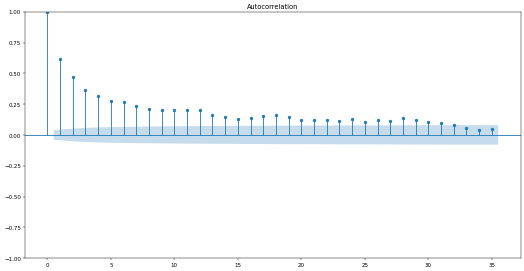

In [21]:
plt.rcParams.update({'figure.figsize' : (16,8), 'figure.dpi' : 40})
plot_acf(df.obs_val.dropna())  
      
plt.show() 

The PACF is a measure of the correlation between the time series and its lagged values, while controlling for the effects of the other intermediate lags.

C:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


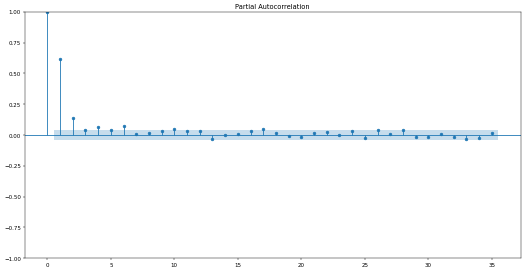

In [22]:
plt.rcParams.update({'figure.figsize' : (16,8), 'figure.dpi' : 40})
plot_pacf(df.obs_val.dropna())  
      
plt.show() 

Fit the arima model

In [23]:
import statsmodels.api as sm 

model = sm.tsa.arima.ARIMA(df.obs_val, order=(4,0,31))
result = model.fit()
print(result.summary())

C:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                obs_val   No. Observations:                 2557
Model:                ARIMA(4, 0, 31)   Log Likelihood               -7397.024
Date:                Sat, 13 May 2023   AIC                          14868.048
Time:                        12:01:56   BIC                          15084.372
Sample:                    01-01-2012   HQIC                         14946.494
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         86.8324      0.457    189.928      0.000      85.936      87.728
ar.L1          0.6861      6.920      0.099      0.921     -12.877      14.249
ar.L2          0.0531      2.640      0.020      0.9

C:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


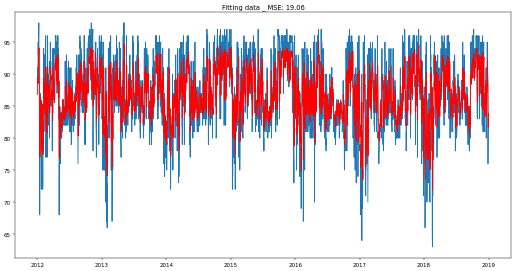

In [24]:
model = ARIMA(df.obs_val, order=(4,0,31))  
results_MA = model.fit()  
plt.plot(df.obs_val)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('Fitting data _ MSE: %.2f'% (((results_MA.fittedvalues-df.obs_val)**2).mean()))
plt.show()

Get the predictions for test values and represent in the plot

<Axes: xlabel='date'>

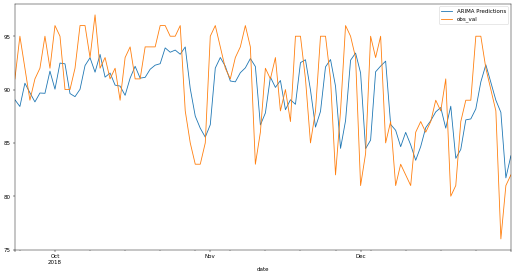

In [25]:
start=len(train)
end=len(train)+len(test)-1
pred=result.predict(start=start,end=end,typ='levels').rename('ARIMA Predictions')
pred.plot(legend=True)
test['obs_val'].plot(legend=True)

Forecast the future predictions up to 12 months ahead and Past 12 months.

<Axes: >

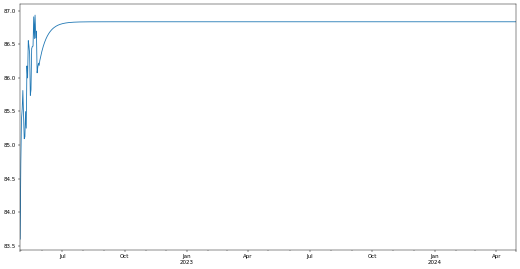

In [26]:
start_date = '2022-04-30'
end_date = '2024-04-30'
date_range = pd.date_range(start=start_date, end=end_date)
predictions_future = result.forecast(steps=len(date_range))
predictions_future.index = date_range
predictions_future
#Save the forecast DataFrame as a CSV file
pd.DataFrame(predictions_future).reset_index().to_csv('forecast3.csv', index=False)
predictions_future.plot()